In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import sys
sys.path.append('../')
import default_style

In [2]:
TS_DATASET_FOLDER = os.path.join('..', 'dataset')
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, 'preprocessed_traces')
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, 'preproc_ts.df')

IMAGE_FOLDER = os.path.join('..', 'images')

TARGET = 'statement'
TRACES = 'syllables_02_STFT'

In [3]:
df = pd.read_csv(DF_PREPROC_FILE).drop(columns=['Unnamed: 0'])
df["actor_number"] = df.actor.apply(lambda x: int(x.split("_")[1]))
df.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,path,sex,begin_s,end_s,...,filtered_fourier_coeffs,syll_0_start_index,syll_1_start_index,syll_2_start_index,syll_3_start_index,syll_4_start_index,syll_5_start_index,syll_6_start_index,syll_7_start_index,actor_number
0,speech,neutral,normal,kids,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.009833,2.252000,...,[1.9371510e-07 1.2311473e-02 1.1168692e-02 ......,0,1128,2240,3200,4304,5208,5808,7448,1
1,speech,neutral,normal,kids,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.068500,2.294667,...,[3.5017729e-07 2.6198970e-02 2.5683273e-02 ......,0,2008,3208,3880,4224,5112,5800,7352,1
2,speech,neutral,normal,dogs,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.012000,2.238500,...,[2.49594450e-07 1.23483688e-02 1.06786685e-02 ...,0,2816,3352,3912,4296,5232,5880,7352,1
3,speech,neutral,normal,dogs,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.008833,2.187167,...,[1.1920929e-07 1.2154780e-02 1.6620707e-02 ......,0,1664,2664,3208,3672,4840,5448,7064,1
4,speech,calm,normal,kids,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.023667,2.534167,...,[1.1920929e-07 2.0026902e-03 7.9688808e-04 ......,0,2088,3584,4832,5800,6944,7560,9056,1


In [4]:
traces_dict = {}
files = os.listdir(TS_PREPROC_FOLDER)

file_path = os.path.join(TS_PREPROC_FOLDER, f"{TRACES}.npy")
traces_dict[TRACES] = np.load(file_path, allow_pickle=True)

In [5]:
traces = traces_dict[TRACES]
# traces = traces.reshape(2452, 729)
traces.shape

(2452, 27, 27)

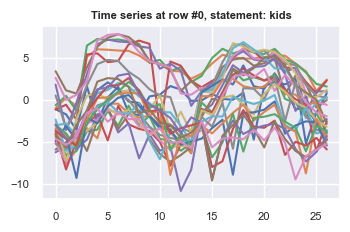

In [6]:
index = 0
statement = df['statement'][index]
plt.plot(traces[index])
plt.title(f'Time series at row #{index}, statement: {statement}')
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# Sets tests to be over actor 19 (excluded)
X_test = traces[df.actor_number > 19]
y_test = df[TARGET][df.actor_number > 19].to_numpy()

# Sets the train and validation inside actors < 19
X_train, X_val, y_train, y_val = train_test_split(  traces[df.actor_number <= 19], 
                                                    df[TARGET][df.actor_number <= 19].to_numpy(), 
                                                    test_size=0.2, random_state=100)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1545, 27, 27), (387, 27, 27), (520, 27, 27), (1545,), (387,), (520,))

/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


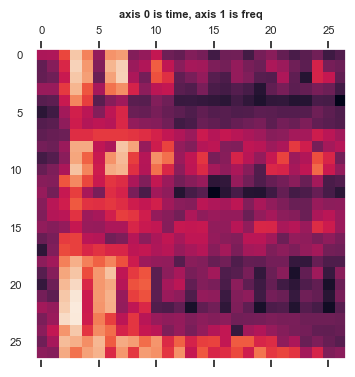

In [9]:
plt.matshow(X_test[0]);plt.grid(ls="")
plt.title("axis 0 is time, axis 1 is freq");

# CNN for statement and syllables 0&2

In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

print(y_train[0])

y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

print(y_train[0])

dogs
0


In [11]:
import optuna
from keras.layers import BatchNormalization, Activation
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Dropout, GlobalAveragePooling1D
from sklearn.metrics import accuracy_score

def build_model(input_shape, n_categories,
                n_conv=0, n_hidden=0, hidden_nodes=32,
                dropout=0.01, filters=8, kernel_size=5, **kwargs):
    
    # Stuff must be given in (timestep, spectral_coeff) format
    n_timesteps = input_shape[0]
    n_features = input_shape[1]

    model = Sequential()

    model.add(Conv1D(filters=filters,
                     kernel_size=kernel_size,
                     activation='relu',
                     input_shape=(n_timesteps, n_features),
                     name="base_conv"
                     ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    for i in range(n_conv):
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Dropout(dropout))

    model.add(GlobalAveragePooling1D())

    for i in range(n_hidden):
        model.add(Dense(hidden_nodes, activation='relu'))

    model.add(Dense(n_categories, activation='softmax'))    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [12]:
# objective function to be minimized
def objective_fun(trial, X, y, validation_X, validation_y):

    n_conv = trial.suggest_int('n_conv', 0, 3)
    n_hidden = trial.suggest_int('n_hidden', 0, 3)
    hidden_nodes = trial.suggest_int('hidden_nodes', 8, 256)
    dropout = trial.suggest_float('dropout', 0, 0.4)
    filters = trial.suggest_int('filters', 2, 16)
    kernel_size = trial.suggest_int('kernel_size', 2, 16)
    batch_size = trial.suggest_int('batch_size', 16, 64)
    epochs = trial.suggest_int('epochs', 5, 90)
    
    print(f"Running little bitch having n_conv={n_conv}, dropout={dropout}, hidden_nodes={hidden_nodes}")
    
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
                        n_hidden=n_hidden,
                        hidden_nodes=hidden_nodes,
                        n_conv=n_conv,
                        dropout=dropout,
                        filters=filters,
                        kernel_size=kernel_size,
                       )

    cnn.fit(X, y, batch_size=batch_size, epochs=epochs, verbose=False)
    
    y_pred = np.argmax(cnn.predict(validation_X), axis=1)

    error = accuracy_score(validation_y, y_pred)

    return error


#study = optuna.create_study(direction='maximize')
#trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
#study.optimize(trial_function, n_trials=150, n_jobs=-1, catch=ValueError)

In [13]:
#best_params = study.best_params
best_params = {'n_conv': 1,
               'n_hidden': 2,
               'hidden_nodes': 52,
               'dropout': 0.018010877668116265,
               'filters': 12,
               'kernel_size': 10,
               'batch_size': 62,
               'epochs': 82}
best_params

{'n_conv': 1,
 'n_hidden': 2,
 'hidden_nodes': 52,
 'dropout': 0.018010877668116265,
 'filters': 12,
 'kernel_size': 10,
 'batch_size': 62,
 'epochs': 82}

In [14]:
cnn = build_model((27,27), 2, **best_params)
cnn.summary()
history = cnn.fit( np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)),
            epochs=best_params["epochs"], 
            batch_size=best_params["batch_size"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_conv (Conv1D)          (None, 18, 12)            3252      
                                                                 
 batch_normalization (Batch  (None, 18, 12)            48        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 18, 12)            0         
                                                                 
 extra_conv_0 (Conv1D)       (None, 9, 12)             1452      
                                                                 
 batch_normalization_1 (Bat  (None, 9, 12)             48        
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 9, 12)             0

In [15]:
from sklearn.metrics import f1_score, classification_report, cohen_kappa_score

y_pred = np.argmax(cnn.predict(X_test), axis=1)

print(f'Cohen k {cohen_kappa_score(y_test, y_pred)}')
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

17/17 [==============================] - 0s 698us/step
Cohen k 0.95
Accuracy 0.975
F1-score [0.97465887 0.97533207]
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       260
           1       0.96      0.99      0.98       260

    accuracy                           0.97       520
   macro avg       0.98      0.98      0.97       520
weighted avg       0.98      0.97      0.97       520



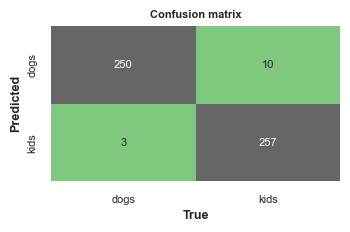

In [16]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True, cmap='Accent', fmt=".4g", cbar=False)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.xticks(ticks=[0.5, 1.5], labels=['dogs', 'kids'])
plt.yticks(ticks=[0.5, 1.5], labels=['dogs', 'kids'])
plt.title('Confusion matrix')
plt.savefig(os.path.join(IMAGE_FOLDER, 'ts_cnn_heatmap.pdf'), format='pdf')
plt.show()

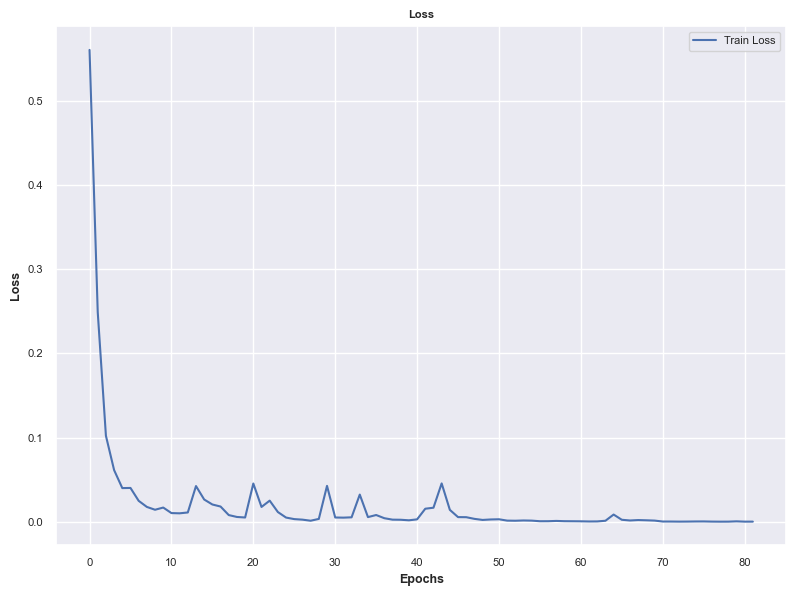

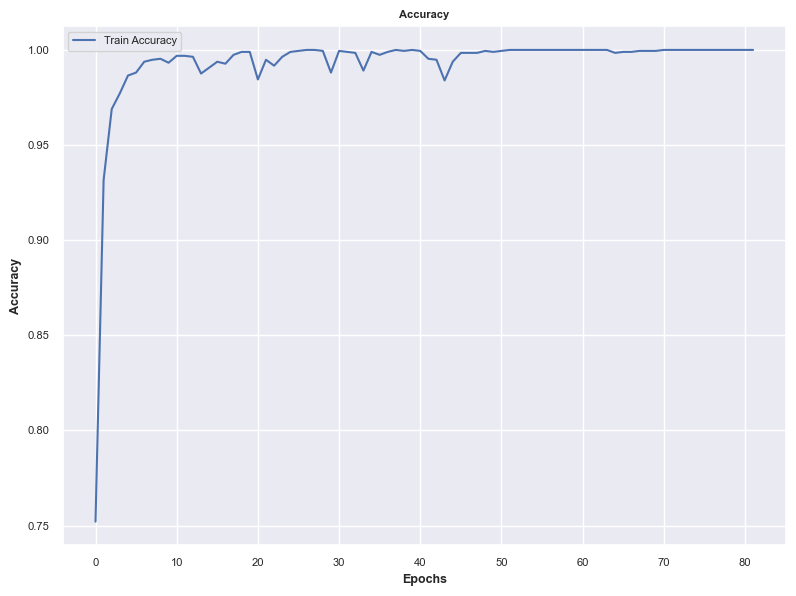

In [17]:
train_loss = history.history['loss']
#val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
#val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Train Loss')
#plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(train_accuracy, label='Train Accuracy')
#plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

   # LIME Explainer 

## setting the classifier for explain_instance using the cnn

In [18]:
from lime import lime_image
from PIL import Image
from skimage.segmentation import mark_boundaries


In [19]:
#To plot the heatmap
rgb_traces = []

for i in range(len(X_test)):
    trace = X_test[i].reshape(27,27)
    
    min_value = np.min(trace)
    max_value = np.max(trace)
    matrice_normalizzata = (trace - min_value) / (max_value - min_value)

    # Crea una matrice 27x27x3 con valori dei canali di colore basati sulla matrice normalizzata
    rosso = matrice_normalizzata
    verde = np.zeros_like(matrice_normalizzata)
    blu = np.zeros_like(matrice_normalizzata)
    heatmap = np.dstack((rosso, verde, blu))
    rgb_traces.append(heatmap)

rgb_traces = np.array([np.array(trace) for trace in rgb_traces])

In [20]:
explainer = lime_image.LimeImageExplainer()

In [21]:
import skimage
from skimage.color import gray2rgb, rgb2gray

def make_prediction(color_img):
    gray_img = rgb2gray(color_img).reshape(-1,27,27)
    preds = cnn.predict(gray_img)
    return preds

In [22]:
#Search for images that aren't full classified
indexes = []

for idx in range(80):
    pred = np.argmax(cnn.predict(X_test[idx].reshape(-1, 27, 27)))

    explanation = explainer.explain_instance(gray2rgb(X_test[idx]), classifier_fn=make_prediction, num_samples=50)
    temp, mask = explanation.get_image_and_mask(pred, num_features=10, hide_rest=False)

    if (not np.all(mask == 0)) & (not np.all(mask == 1)):
        print("Prediction: ", pred)
        print(f"Actual: {y_test[idx]} \tindex: {idx}")
        indexes.append(idx)

explained = pd.DataFrame()
explained['Index'] = indexes
explained['Prediction'] = np.argmax(cnn.predict(X_test[indexes].reshape(-len(indexes), 27, 27)), axis=1)
explained['Actual'] = y_test[indexes]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 8ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step
Prediction:  1
Actual: 1 	index: 4
1/1 [==============================] - 0s 12ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 9ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 9ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 7ms/step
Prediction:  0
Actual: 0 	index: 14
1/1 [==============================] - 0s 12ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 7ms/step
Prediction:  0
Actual: 0 	index: 19
1/1 [==============================] - 0s 8ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step
Prediction:  0
Actual: 0 	index: 27
1/1 [==============================] - 0s 13ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 9ms/step
Prediction:  0
Actual: 0 	index: 31
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 12ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 9ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 9ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step
Prediction:  0
Actual: 0 	index: 38
1/1 [==============================] - 0s 9ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 8ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 9ms/step
Prediction:  1
Actual: 1 	index: 44
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 9ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 8ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 10ms/step
Prediction:  1
Actual: 0 	index: 62
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step
Prediction:  1
Actual: 1 	index: 65
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step
Prediction:  0
Actual: 0 	index: 67
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 33ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 8ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


In [23]:
explained

,Index,Prediction,Actual
0,4,1,1
1,14,0,0
2,19,0,0
3,27,0,0
4,31,0,0
5,38,0,0
6,44,1,1
7,62,1,0
8,65,1,1
9,67,0,0


In [24]:
idx = 0 #choose the index between 0 and len(indexes)
explanation = explainer.explain_instance(gray2rgb(X_test[indexes[idx]]), classifier_fn=make_prediction, num_samples=50)
temp, mask = explanation.get_image_and_mask(y_test[indexes[idx]], num_features=10, hide_rest=False)

1/1 [==============================] - 0s 11ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


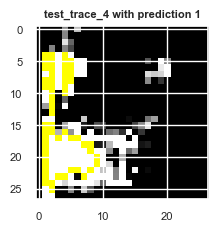

In [25]:
marked_image = mark_boundaries(temp , mask)
plt.title(f'test_trace_{indexes[idx]} with prediction {explained["Prediction"][idx]}')
plt.imshow(marked_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'LIME Explanation')

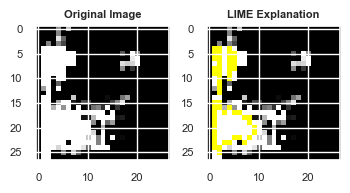

In [26]:
plt.subplot(1,2, 1)
plt.imshow(gray2rgb(X_test[indexes[0]]), cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(marked_image)
plt.title('LIME Explanation')

In [27]:
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

def plot_comparison(main_image, image, mask):
    fig = plt.figure(figsize=(15,5))

    ax = fig.add_subplot(141)
    ax.imshow(main_image, cmap="gray")
    ax.set_title("Original Image")
    ax = fig.add_subplot(142)
    ax.imshow(image)
    ax.set_title("Image")
    ax = fig.add_subplot(143)
    ax.imshow(mask)
    ax.set_title("Mask")
    ax = fig.add_subplot(144)
    ax.imshow(marked_image)
    ax.set_title("Image+Mask Combined")

    plt.show()

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 14ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: kids talk
Actual: kids talk
Emotion: sad
Emotional Intensity: normal
Sex: M


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


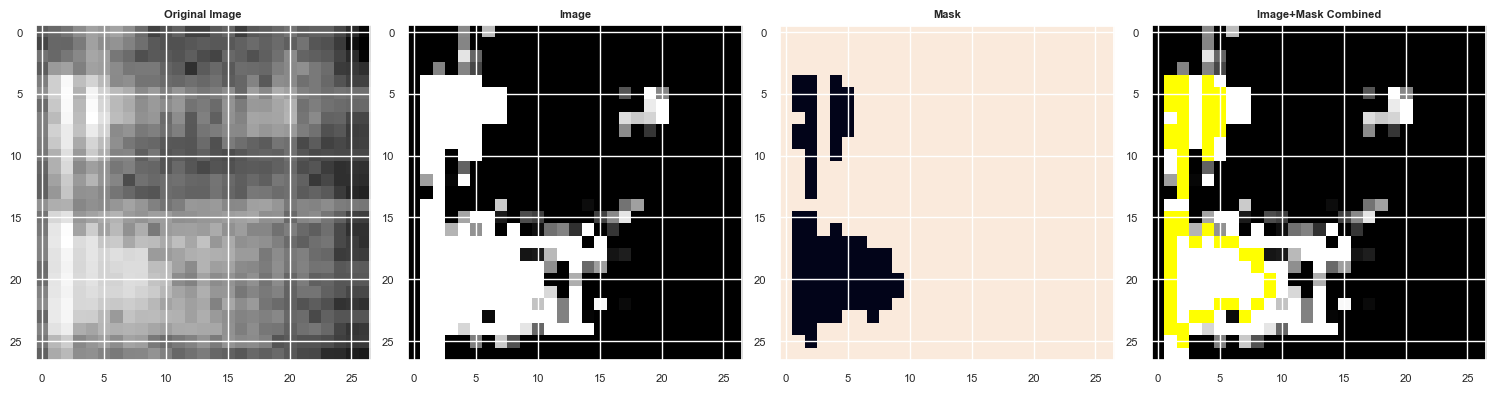

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 18ms/step
Predicted: dogs sit
Actual: dogs sit
Emotion: angry
Emotional Intensity: normal
Sex: M


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


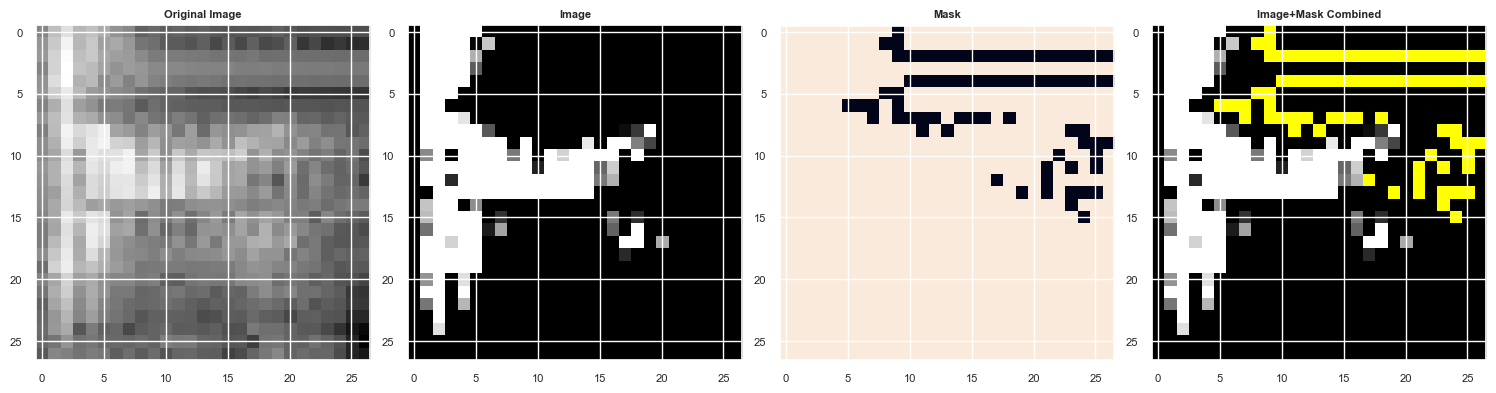

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 23ms/step
Predicted: dogs sit
Actual: dogs sit
Emotion: fearful
Emotional Intensity: normal
Sex: M


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


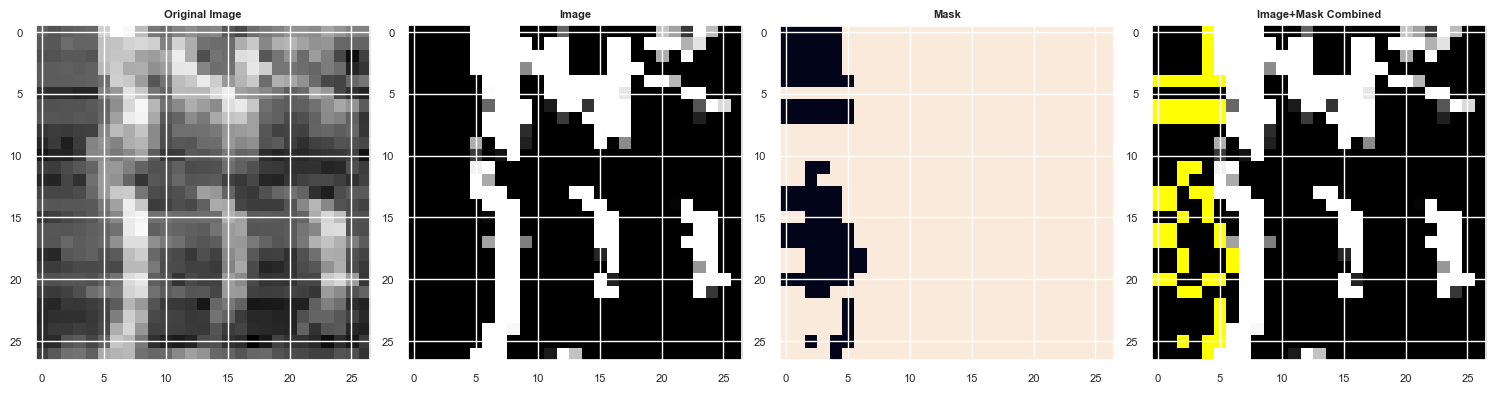

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 12ms/step
Predicted: dogs sit
Actual: dogs sit
Emotion: neutral
Emotional Intensity: normal
Sex: F


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


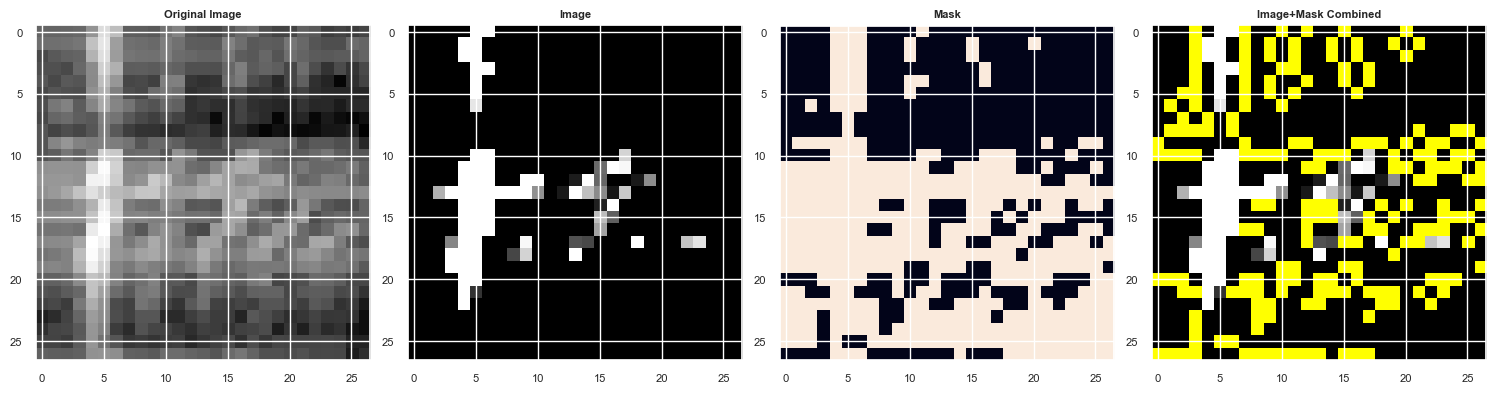

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: dogs sit
Actual: dogs sit
Emotion: calm
Emotional Intensity: normal
Sex: F


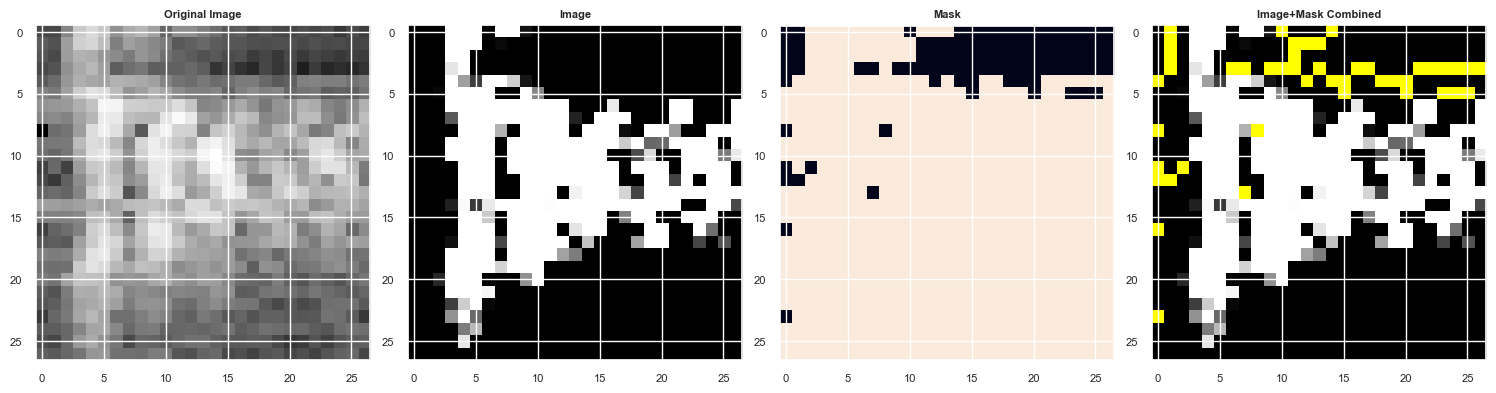

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: dogs sit
Actual: dogs sit
Emotion: calm
Emotional Intensity: strong
Sex: F


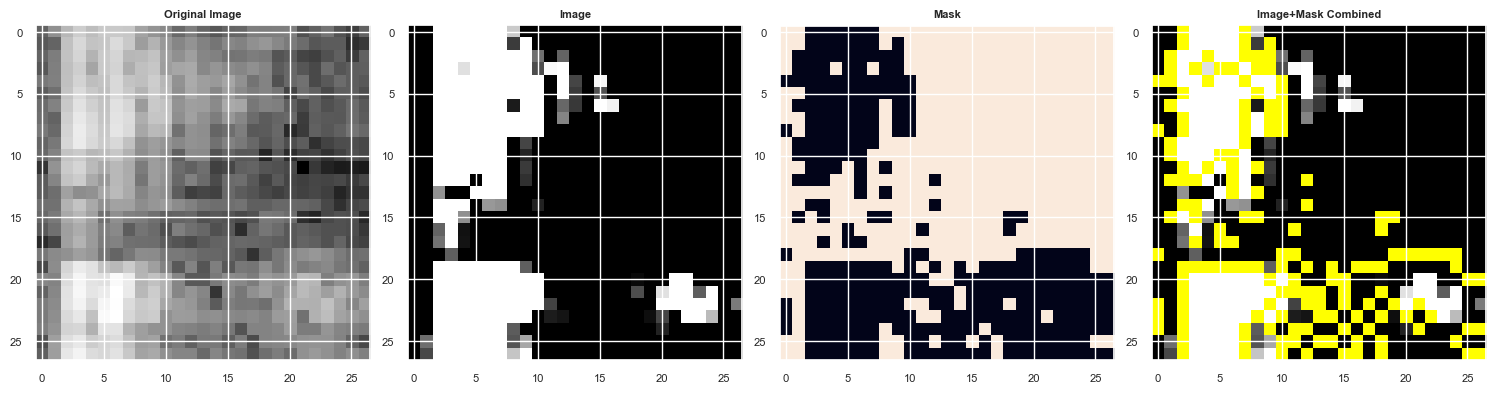

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 11ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: kids talk
Actual: kids talk
Emotion: happy
Emotional Intensity: strong
Sex: F


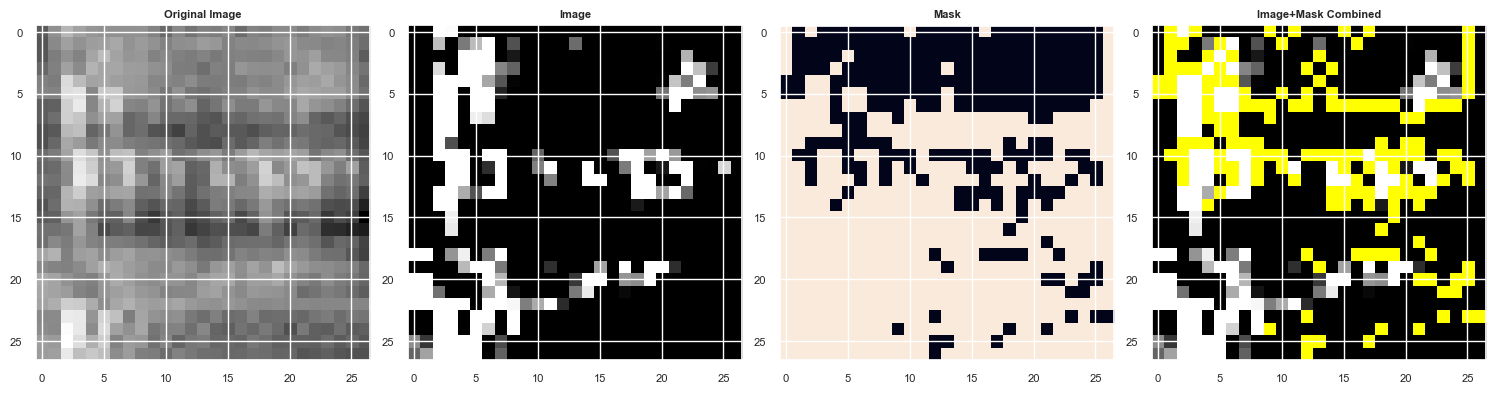

1/1 [==============================] - 0s 9ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: kids talk
Actual: dogs sit
Emotion: angry
Emotional Intensity: strong
Sex: F


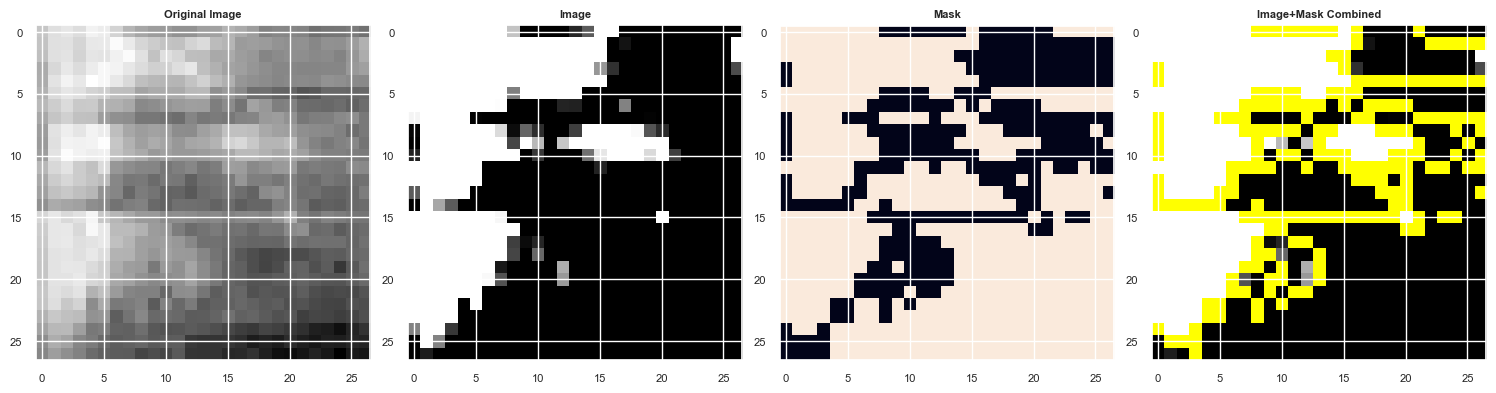

1/1 [==============================] - 0s 8ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step
Predicted: kids talk
Actual: kids talk
Emotion: fearful
Emotional Intensity: normal
Sex: F


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


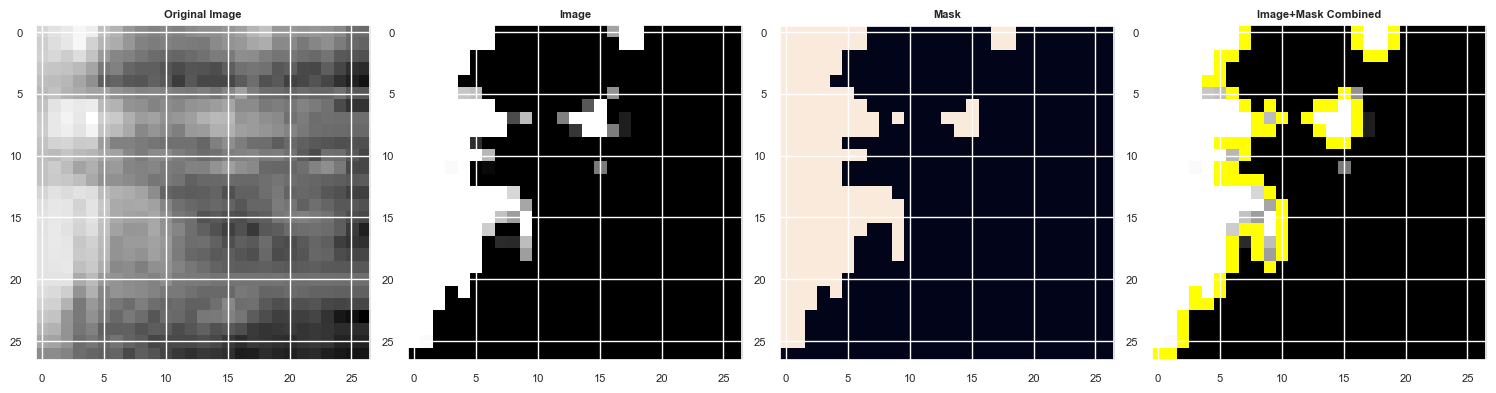

1/1 [==============================] - 0s 9ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: dogs sit
Actual: dogs sit
Emotion: fearful
Emotional Intensity: strong
Sex: F


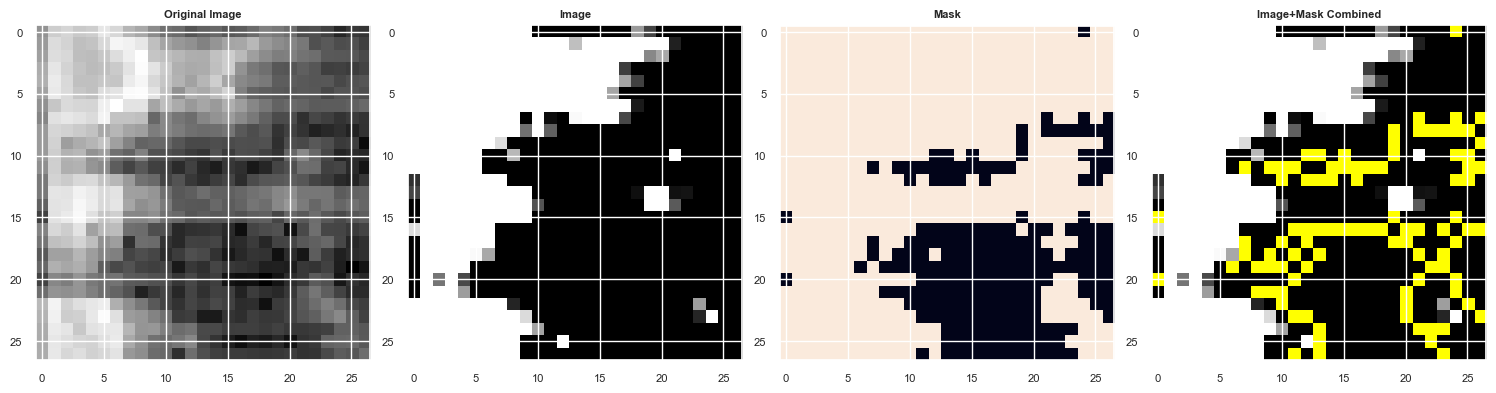

In [28]:
for i in indexes:
    pred = np.argmax(cnn.predict(X_test[i].reshape(-1, 27, 27)))

    explanation = explainer.explain_instance(gray2rgb(X_test[i]), classifier_fn=make_prediction, num_samples=50)
    temp, mask = explanation.get_image_and_mask(pred, num_features=10, hide_rest=False)
    marked_image = mark_boundaries(temp , mask)

    pred_statement = 'dogs sit' if pred == 0 else 'kids talk'
    actual_statement = 'dogs sit' if y_test[i] == 0 else 'kids talk'

    print(f'Predicted: {pred_statement}')
    print(f'Actual: {actual_statement}')
    print(f'Emotion: {df["emotion"][i + len(X_train)]}')
    print(f'Emotional Intensity: {df["emotional_intensity"][i + len(X_train)]}')
    print(f'Sex: {df["sex"][i + len(X_train)]}')

    plot_comparison(X_test[i], gray2rgb(X_test[i]), mask)